In [3]:
from sklearn.datasets import make_regression
import numpy as np
import pandas as pd
%matplotlib notebook
from matplotlib import pyplot as plt
import scipy.stats

# Preprocessing

Primerament, he volgut observar les dades proveides en el dataset, entrendre la seva distribució o si ens feia falta fer neteja d'aquest, o per exemple balancejar-lo.


In [8]:
from src.generate_features import *

# Visualitzarem només 3 decimals per mostra
pd.set_option('display.float_format', lambda x: '%.3f' % x)

dataset_train, dataset_test, dataset_validate, dataset_full = generate_dataset(type='non-nlp')

data = dataset_test.values
target = dataset_test.target

x = data[:, :18]
y = target

print("Dimensionalitat de la BBDD:", dataset_full.shape)
print("Dimensionalitat de les entrades X", x.shape)
print("Dimensionalitat de l'atribut Y", y.shape)

Index(['COLUMNS: decade', 'COLUMNS: danceability', 'COLUMNS: energy',
       'COLUMNS: key', 'COLUMNS: loudness', 'COLUMNS: mode',
       'COLUMNS: speechiness', 'COLUMNS: acousticness',
       'COLUMNS: instrumentalness', 'COLUMNS: liveness', 'COLUMNS: valence',
       'COLUMNS: tempo', 'COLUMNS: duration_ms', 'COLUMNS: time_signature',
       'COLUMNS: chorus_hit', 'COLUMNS: sections', 'COLUMNS: target'],
      dtype='object')
Dimensionalitat de la BBDD: (41106, 17)
Dimensionalitat de les entrades X (18499, 17)
Dimensionalitat de l'atribut Y (18499,)


Dintre de la generació del nostre dataset, es a dir la carrega del mateix en un Dtaframe de Pandas i possible neteja, he dividit el proces en 2 parts. Primerament, vaig voler probar a  utilitzar el dataset proveit tal qual, eliminant les columnes amb text com per exemple el nom del artista o URL de spotify de la canço. Més endavant, (apartat NLP d'aquest notebook) vaig voler probar a utilitzar Natural Language Processing per probar si per exemple podria extreure coneixemtn util dels noms de les cançons.

Ambdos idees es tradueixen en la funció generate_dataset que li puc passar l'argument 'NLP' o 'non-nlp' respectivament. 

El meu dataset estava dividit en diferents .csv depenent de cada decada:

    - 60 (Decada dels 60 - 1960-1970)
    - 70 (Decada dels 60 - 1970-1980)
    - 80 (Decada dels 60 - 1980-1990)
    - 90 (Decada dels 60 - 1990-2000)
    - 00 (Decada dels 60 - 2000-2010)
    - 10 (Decada dels 60 - 2010-2020)
    
Aleshores, la idea que he seguit es la de juntar tots els datasets desde la decada dels 60 fins als 90 per a train, deixant la ultima o ultimes decades (00, 10) per dades de test. Com veurem més endavant cada decada es important, la música ha anat evolucionant, aixi com el concepte de canço exitosa.

Primerament observem el nombre de valors nulls. Podem observar que no presentem cap.

In [3]:
print("Per comptar el nombre de valors no existents:")
print(dataset_full.isnull().sum())

Per comptar el nombre de valors no existents:
decade              0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
duration_ms         0
time_signature      0
chorus_hit          0
sections            0
target              0
dtype: int64


El nostre arbre tampoc esta desbalancejat, tenim el mateix nombre de dades de ambdos classes:

In [4]:
print(dataset_full['target'].value_counts())


1    20553
0    20553
Name: target, dtype: int64


Per introduir-les, trobem aquestes variables depenents el seu valor de cada canço. Com veurem més endavant hi ha variiables que han tingut més importancia que altres durant les diferents decades peró que realment s'ha mantingut sempre com les numero 1.
Aquestes dades s'extreuen amb la API de Spotify de Sound Analysis, que també he utilitzat en la creació de la pagina web.

In [5]:
print("Per visualitzar les primeres 5 mostres de la BBDD:")
dataset_full.head() 

Per visualitzar les primeres 5 mostres de la BBDD:


,decade,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target
0,1960,0.417,0.620,3,-7.727,1,0.040,0.490,0.000,0.078,0.845,185.655,173533,3,32.950,9,1
1,1960,0.498,0.505,3,-12.475,1,0.034,0.018,0.107,0.176,0.797,101.801,213613,4,48.825,10,0
2,1960,0.657,0.649,5,-13.392,1,0.038,0.846,0.000,0.119,0.908,115.940,223960,4,37.227,12,0
3,1960,0.590,0.545,7,-12.058,0,0.104,0.706,0.025,0.061,0.967,105.592,157907,4,24.755,8,0
4,1960,0.515,0.765,11,-3.515,0,0.124,0.857,0.001,0.213,0.906,114.617,245600,4,21.799,14,0


Anem a analtizar les dades. Com tenim diferents decades, vaig observar que potser, clar, la música a anat evolucionant amb el temps, aixi com els gustos de la gent, o factors que determinen quina canó es un exit. Per tant, primerament vaig mostrar en una grafica la mitjana de hits i no hits depenent de cada factor.

<IPython.core.display.Javascript object>


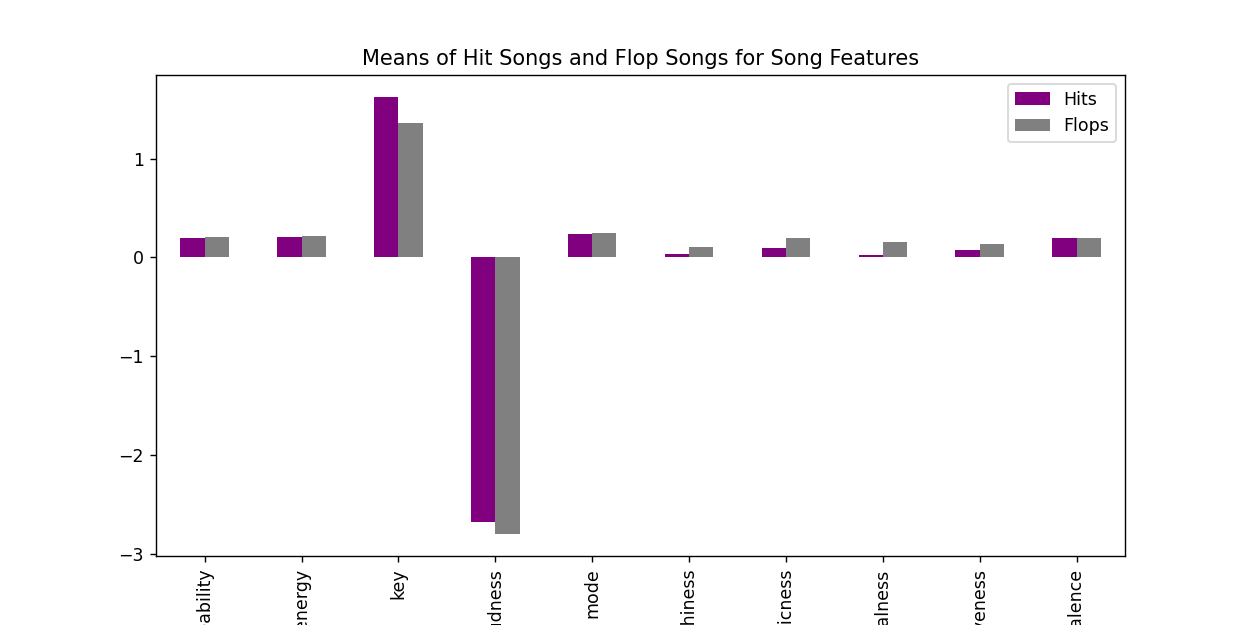

In [6]:
from sklearn.preprocessing import StandardScaler 
#create two var lists, one with Spotify's features (spfeatures_var_list) and one with the song traits (song_traits_var_list)
spfeatures_var_list = ['danceability', 'energy', 'key', 'loudness','mode', 'speechiness', 'acousticness', 
                       'instrumentalness', 'liveness','valence']
song_traits_var_list = ['key', 'loudness','tempo', 'time_signature', 'chorus_hit','sections'] 
#duration_ms has been removed since it has such larger numbers than the other variables 

all_songs_hits = dataset_train[spfeatures_var_list].loc[dataset_train['target'] == 1]

all_songs_flops = dataset_train[spfeatures_var_list].loc[dataset_train['target'] == 0]

#create a dataframe that includes the means for hits and flops
hits_means = pd.DataFrame(all_songs_hits.describe().loc['mean'])
flops_means = pd.DataFrame(all_songs_flops.describe().loc['mean'])
means_joined = pd.concat([hits_means,flops_means], axis = 1)
means_joined.columns = ['hit_mean', 'flop_mean']

ss = StandardScaler()
means_joined_scaled = pd.DataFrame(ss.fit_transform(means_joined),index= means_joined.index, columns = means_joined.columns)
means_joined_scaled


means_joined_scaled.plot(kind = 'bar', figsize=(10, 5), color = ('purple', 'grey'), title = 'Means of Hit Songs and Flop Songs for Song Features')
plt.legend(labels=['Hits', 'Flops'], loc='upper right')
plt.show()
plt.show()

Com es pot anar observant, la key o tonalitat musical en la que es troba la cançó així com el loudness, presenten molt més pes que les altres.
Anem a veure l'histograma de cada variable per buscar les distribucions de les nostres variables

<IPython.core.display.Javascript object>


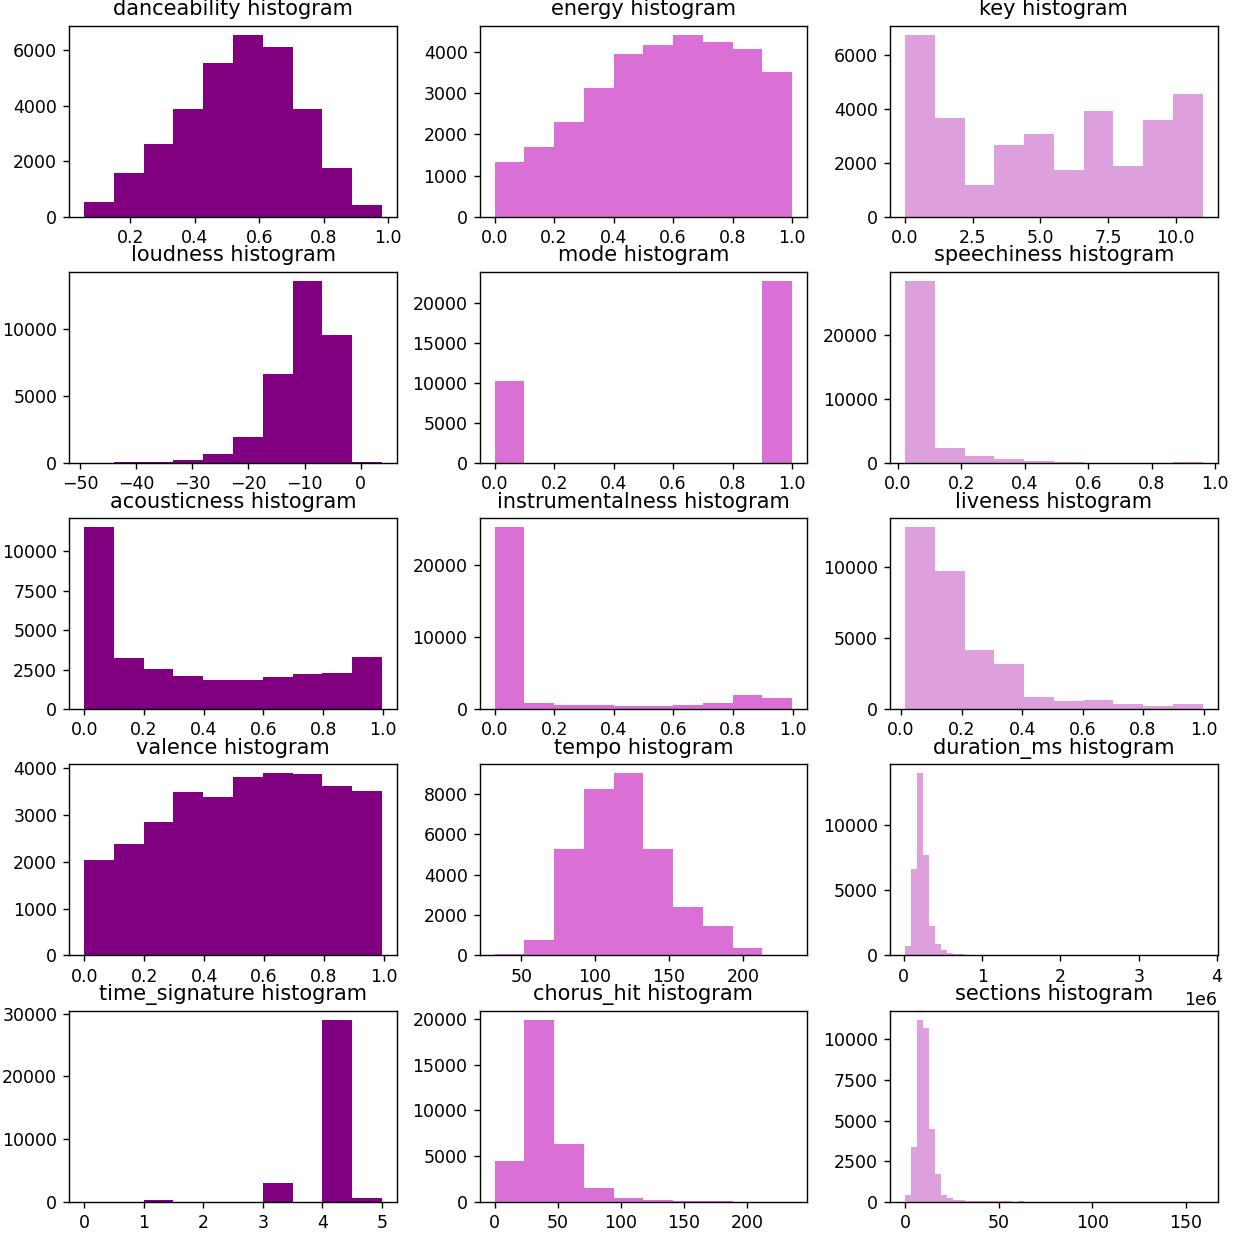

In [7]:
#create histograpms of all the variables to see distributions
fig, ax = plt.subplots(5,3, figsize=(10, 10))
fig.tight_layout()

def hist_plot(row, column, variable, binsnum, color):
    ax[row, column].hist(dataset_train[variable], bins = binsnum, color = color)
    ax[row, column].set_title(variable + ' histogram')
    
hist_plot(0, 0, 'danceability', 10, 'purple')
hist_plot(0, 1, 'energy', 10, 'orchid')
hist_plot(0, 2, 'key', 10, 'plum')
hist_plot(1,0, 'loudness', 10, 'purple')
hist_plot(1,1, 'mode', 10, 'orchid')
hist_plot(1,2, 'speechiness', 10, 'plum')
hist_plot(2,0, 'acousticness', 10, 'purple')
hist_plot(2,1, 'instrumentalness', 10, 'orchid')
hist_plot(2,2, 'liveness', 10, 'plum')
hist_plot(3,0, 'valence', 10, 'purple')
hist_plot(3,1, 'tempo', 10, 'orchid')
hist_plot(3,2, 'duration_ms', 50, 'plum')
hist_plot(4,0, 'time_signature', 10, 'purple')
hist_plot(4,1, 'chorus_hit', 10, 'orchid')
hist_plot(4,2, 'sections', 50, 'plum')

plt.show()

Aquí hi ha alguns patrons interessants: les cançons solen ser més ballables que menys ballables, les cançons tendeixen a tenir més energia que menys energia, la tonalitat de C és la tonalitat més popular, les cançons solen ser inferiors a 10 decibels, la majoria de les cançons estan en escales majors, la majoria de les cançons contenen més música que la parla, la majoria de les cançons no són en directe, la majoria de les cançons no són acústiques, la majoria de les cançons contenen música, hi ha una bona barreja de cançons alegres i tristes, la majoria de cançons tenen uns 80-90 pulsacions per minut i la majoria de cançons són en 4/4 de temps. 

En el apartat de Model Testing, s'observara amb més profunditat altres factors de les dades.

#  Model Testing

Primer vaig començar per probar diferents models estadistics classificadors per veure quin hem donava millor resultat. L'escull dels mateixos ha sigut un process de busqueda en internet dels més recomenats, i amb comparar amb altres persones que han treballat en aquest cas Kaggle també.

In [8]:
from src.train_model import *

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB

x_train, x_test, y_train, y_test = get_train_test(dataset_train, dataset_test, dataset_validate)


models = {
    "Logistic Regression": LogisticRegression(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Support Vector Machine (Linear Kernel)": LinearSVC(),
    "Random Forest": RandomForestClassifier(),
    "Naive Bayes": GaussianNB(),
    "Neural Net": MLPClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "Gradient Boosting": GradientBoostingClassifier()
}

for name, model in models.items():
    print(name)
    model.fit(x_train, y_train)
    print(name + " trained.")

for name, model in models.items():
    print(name + ": {:.2f}%".format(model.score(x_test, y_test) * 100))
    print("----------------")
    print("Model evaluation {0}".format(name))
    evaluate_model(x_train, x_test, y_train, y_test, model.predict(x_test), model)
    # print("###")
    # print("Cross validation {0}".format(name))
    # print("###")
    # cross_val_preds = cross_val_predict(model, x_val, y_val)


C:\Users\elblo\Desktop\Universidad\3r Año\1r Semestre\APC\Kaggle\MD3 Spotify\src\train_model.py:19: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  x_train = dataset_train.drop(['target'], 1).values  # values converts it into a numpy array
C:\Users\elblo\Desktop\Universidad\3r Año\1r Semestre\APC\Kaggle\MD3 Spotify\src\train_model.py:22: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  x_test = dataset_test.drop(['target'], 1).values  # values converts it into a numpy array


Logistic Regression
Logistic Regression trained.
K-Nearest Neighbors
K-Nearest Neighbors trained.
Decision Tree
Decision Tree trained.
Support Vector Machine (Linear Kernel)


C:\Users\elblo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Support Vector Machine (Linear Kernel) trained.
Random Forest
Random Forest trained.
Naive Bayes
Naive Bayes trained.
Neural Net
Neural Net trained.
AdaBoost
AdaBoost trained.
Gradient Boosting
Gradient Boosting trained.
Logistic Regression: 50.80%
----------------
Model evaluation Logistic Regression
Accuracy: 50.7973403967782
Precision: 50.60750132065505
Recall: 62.20779220779221
F1 score: 0.5581124381007865
Training MSE:  0.48620951801733314
Test model MSE 0.49202659603221793
K-Nearest Neighbors: 57.08%
----------------
Model evaluation K-Nearest Neighbors
Accuracy: 57.08416671171415
Precision: 56.519995990778796
Recall: 61.028138528138534
F1 score: 0.586876203361607
Training MSE:  0.21444427550554965
Test model MSE 0.42915833288285854
Decision Tree: 71.46%
----------------
Model evaluation Decision Tree
Accuracy: 71.45791664414293
Precision: 71.19914346895075
Recall: 71.96969696969697
F1 score: 0.7158234660925727
Training MSE:  0.00012163600425726015
Test model MSE 0.28542083355857

C:\Users\elblo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training MSE:  0.5006537935228828
Test model MSE 0.4994864587274988
Random Forest: 80.23%
----------------
Model evaluation Random Forest
Accuracy: 80.22595815990053
Precision: 77.49753694581281
Recall: 85.12987012987013
F1 score: 0.8113460546673544
Training MSE:  0.00012163600425726015
Test model MSE 0.19774041840099466
Naive Bayes: 62.09%
----------------
Model evaluation Naive Bayes
Accuracy: 62.08984269419968
Precision: 57.4576384702967
Recall: 92.84632034632034
F1 score: 0.7098589218484961
Training MSE:  0.37360498707617457
Test model MSE 0.3791015730580031
Neural Net: 65.10%
----------------
Model evaluation Neural Net
Accuracy: 65.09541056273312
Precision: 61.308411214953274
Recall: 81.64502164502164
F1 score: 0.7003016941285681
Training MSE:  0.34045917591607117
Test model MSE 0.3490458943726688
AdaBoost: 76.24%
----------------
Model evaluation AdaBoost
Accuracy: 76.24195902481216
Precision: 73.16630008606676
Recall: 82.8030303030303
F1 score: 0.7768695740468091
Training MSE: 

Com podem veure, el model de Random Forest ens retorna l'accuracy més alt aixi com una precissió i recall més bona. Per tant haurem de treballar amb aquest. El seguent que volia veure era buscar quines variables ens ajuden a diferenciar entre HIT i no HIT.

Anem a crear un model de random forest i provar rendiments

<IPython.core.display.Javascript object>


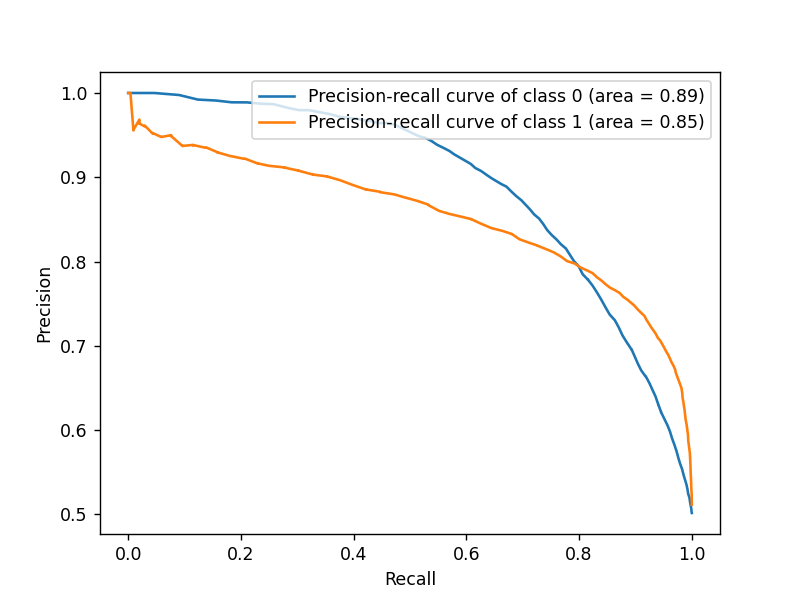

<IPython.core.display.Javascript object>


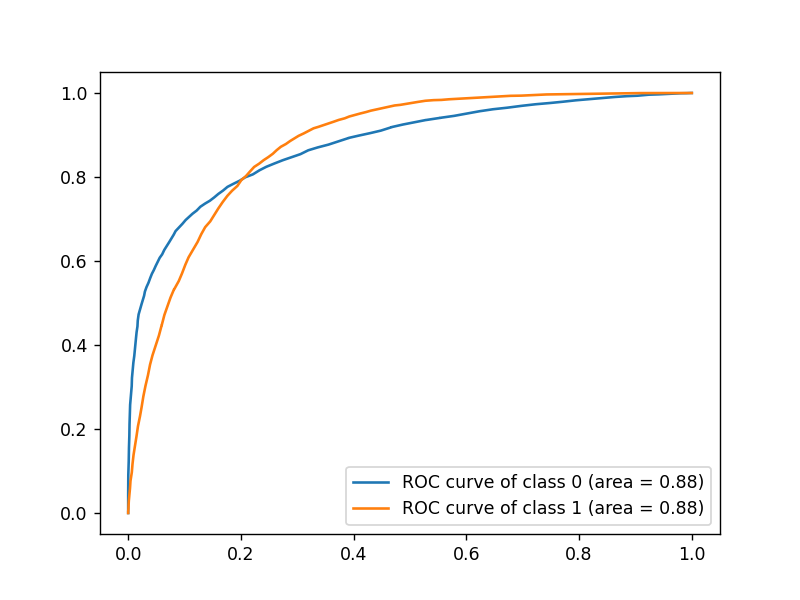

In [9]:
from src.graphic_utils import *
import matplotlib as mpl
import seaborn as sns

RF = RandomForestClassifier()
RF.fit(x_train, y_train)
y_pred = RF.predict(x_test)

probs = RF.predict_proba(x_test)
roc_and_pr(y_test, probs)



Ambdos curbes ens indican que tot i que podria arribar a ser més perfecte, el nostre model es bastant bo classificant, veiem com la area per sota de la corva es molt propera a 1.

<IPython.core.display.Javascript object>


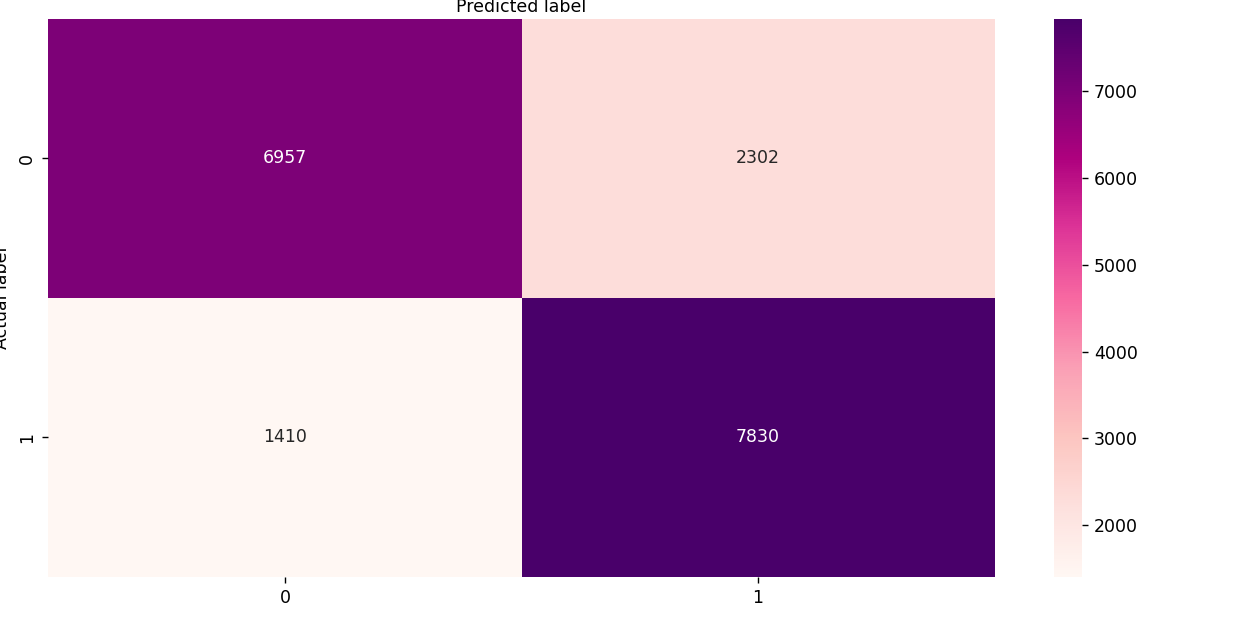

In [10]:
#create a confusion matrix to see the efficacy of the model
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

#create a figure/heatmap of the confusion matrix for a better visual
mpl.rcParams['figure.figsize']=(10,5)
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="RdPu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

La matriu de confusió demostra que el model va identificar correctament els encerts i els fracàs la majoria del temps.
Podem observar com al pas de les decades, com de importants son cara atribut de les cançons ja que possiblement depenent de la decada, li donaven mes importancia potser al tant per cent de ballable  i no tant al tant percent de instrumentabilitat.


<IPython.core.display.Javascript object>


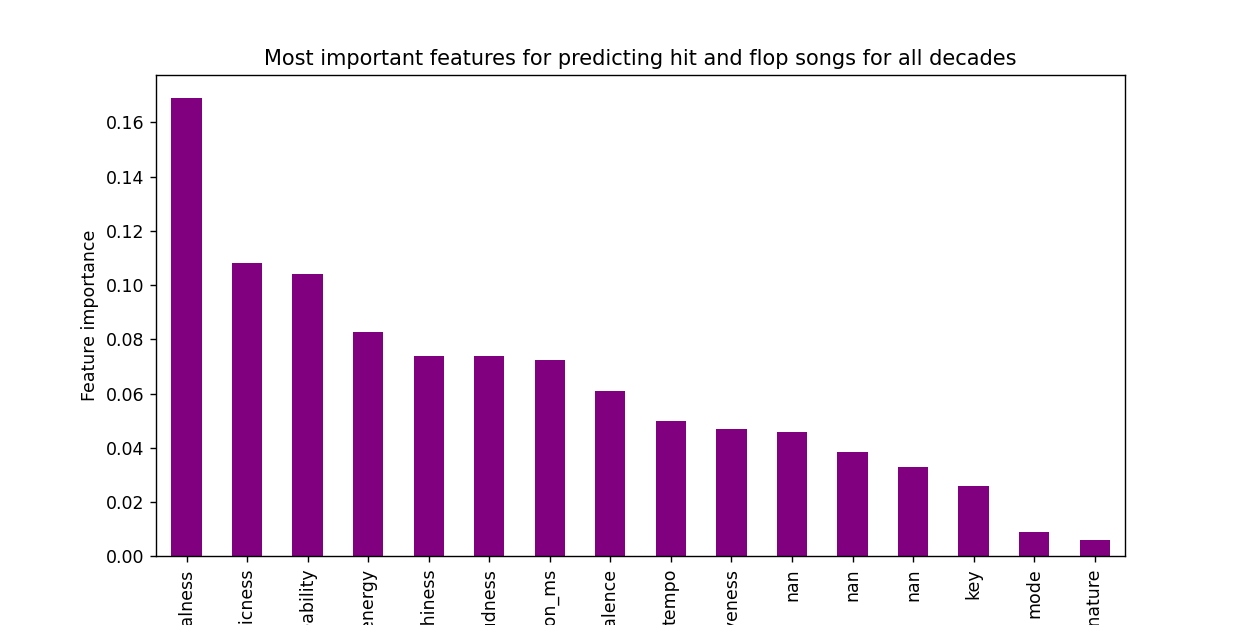

In [11]:
indep_columns = ['danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms', 'time_signature']

#create a dataframe of the feature importances to determine which variables are the most important in determining a hit
all_songs_feat = RF.feature_importances_
df_indep_columns = pd.DataFrame(indep_columns)
df_all_songs_feat = pd.DataFrame(all_songs_feat)
all_songs_feat_vars = pd.concat([df_indep_columns, df_all_songs_feat], axis = 1)
all_songs_feat_vars.columns = ['Variable', 'Feature importance all decades']
all_songs_feat_vars = all_songs_feat_vars.set_index('Variable')
all_songs_feat_vars = all_songs_feat_vars.sort_values(by=['Feature importance all decades'], ascending = False)
all_songs_feat_vars
all_songs_feat_vars.to_csv('all_songs_feat.csv', index = False) #create a CSV file of the new dataframe

all_songs_feat_vars.plot(kind='bar', color = "purple", title = "Most important features for predicting hit and flop songs for all decades", legend = None)
plt.ylabel('Feature importance')
plt.show()

Durant totes les dècades, instrumentalness, danceability, acousticness, duration_ms, i loudness van ser els millors predictors de si una cançó era un èxit. Tot i aixi, he comprobat que deixant aquests valors com a unics atributs d'entrada, les metriques empitjoraven. Aixó ens indica que aquests atributs son importants en tant a visió general de la societat i els seus gustos en cada decada, pero els altres atributs més tecnics de cada cançó son desconeguts pel public general pero jugent gran paper.

# Proves amb NLP (NLTK)



Index(['Unnamed: 0', 'decade', 'track', 'artist', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms',
       'time_signature', 'chorus_hit', 'sections', 'target'],
      dtype='object')


<IPython.core.display.Javascript object>


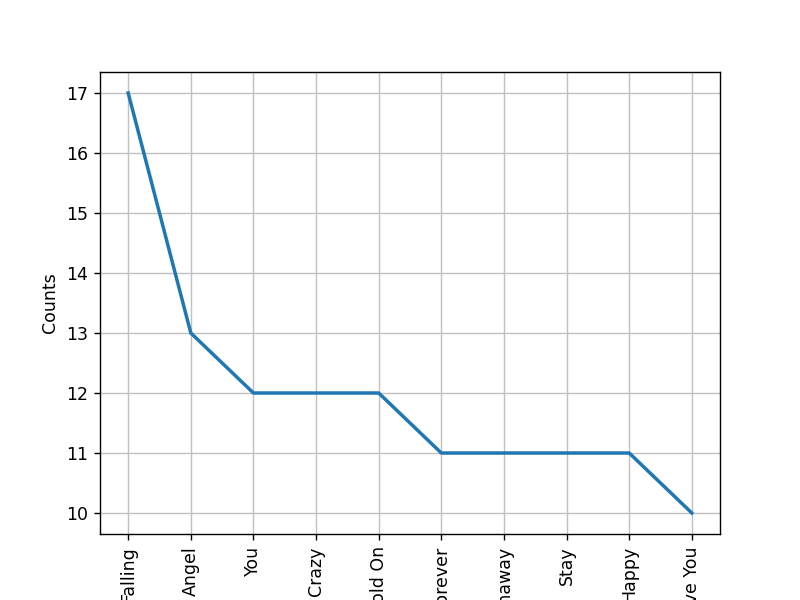

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [17]:
import nltk
from src.dataset_utils import *

dataset_full_nlp = load_dataset('data/dataset_joined_full.csv')

print(dataset_full_nlp.columns)

tokens = dataset_full_nlp['track'].values

freq = nltk.FreqDist(tokens)

freq.plot(10, cumulative=False)

In [16]:
from src.generate_features import *
from src.train_model import *
from src.score_model import *
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# dataset_train, dataset_test, dataset_validate, dataset_full = generate_dataset(type='non-nlp')

dataset_full = generate_dataset(type='nlp')

# show heatmap
sns.heatmap(dataset_full.corr(), cmap="YlGnBu", annot=True)
plt.tight_layout()
plt.show()

# x_train, x_test, y_train, y_test = get_train_test(dataset_train, dataset_test, dataset_validate)
x_train, x_test, y_train, y_test = get_train_test(dataset_full=dataset_full)


RF, y_pred = train_model(x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test, model_name='RF')

accuracy, precision, recall, f1 = evaluate_model(x_train, x_test, y_train, y_test, y_pred, RF)

filename = 'deploy/model-spotify.sav'
joblib.dump(RF, filename)


C:\Users\elblo\Desktop\Universidad\3r Año\1r Semestre\APC\Kaggle\MD3 Spotify\src\train_model.py:20: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  x = dataset_full.drop(['target'], 1).values  # values converts it into a numpy array


Accuracy: 99.65945025541231
Precision: 99.58169291338582
Recall: 99.72893050763923
F1 score: 0.9965525732578182
Training MSE:  0.4983882739326116
Test model MSE 0.5064461201654099


['deploy/model-spotify.sav']

In [ ]:
tfidf

count-vectorizer

histograma